# Classification Models

Performing classification prediction on red and white wine data with logistic regression and a support vector classifier.

In [1]:
# For calculation and data storage
import numpy as np
import pandas as pd

# For visualizations
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

We begin by loading in the red and white wine data, then performing a train test split for each.

In [2]:
# Load the red and white wine datasets
red_wine = pd.read_csv('./data/winequality-red.csv', sep = ';')
white_wine = pd.read_csv('./data/winequality-white.csv', sep = ';')

In [3]:
from sklearn.model_selection import train_test_split

red_train, red_test = train_test_split(red_wine, test_size=0.2, random_state=42,
                                       stratify=red_wine['quality'])

white_train, white_test = train_test_split(white_wine, test_size=0.2, random_state=42,
                                           stratify=white_wine['quality'])

def extract_X_and_Y(df, target):
    X = df.drop(target, axis=1)
    Y = df[target]
    return X, Y

red_X_train, red_Y_train = extract_X_and_Y(red_train, 'quality')
red_X_test, red_Y_test = extract_X_and_Y(red_test, 'quality')

white_X_train, white_Y_train = extract_X_and_Y(white_train, 'quality')
white_X_test, white_Y_test = extract_X_and_Y(white_test, 'quality')

Confirming the size of each set:

In [4]:
red_X_train.shape, red_X_test.shape

((1279, 11), (320, 11))

In [5]:
white_X_train.shape, white_X_test.shape

((3918, 11), (980, 11))

In [6]:
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix

# Function to plot the confusion matrix between true and predicted values
# and also prints and returns the precision of each label
def confusion_matrix_and_class_precision(Y_true, Y_pred, labels, title, color):
    class_precision = precision_score(Y_true, Y_pred, average=None, zero_division=0.0)
    cm = confusion_matrix(Y_true, Y_pred)
    
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt="d", cmap=color, xticklabels=labels, yticklabels=labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()
    
    print(class_precision)
    return class_precision

In [7]:
### Ignore warnings for final notebook output.
import warnings, os
warnings.simplefilter('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

## Logistic Regression

### Red Wine

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import GridSearchCV

red_logit_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('one-v-rest', OneVsRestClassifier(LogisticRegression()))
])

red_logit_param_grid = {
    'one-v-rest__estimator__penalty': ['l1', 'l2'],
    'one-v-rest__estimator__C': np.logspace(-2, 4, 7),
    'one-v-rest__estimator__solver': ['liblinear'],
    'one-v-rest__estimator__random_state': [42]
}

red_logit_grid = GridSearchCV(red_logit_pipeline, red_logit_param_grid, scoring='precision_macro')
red_logit_grid.fit(red_X_train, red_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('one-v-rest',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             param_grid={'one-v-rest__estimator__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'one-v-rest__estimator__penalty': ['l1', 'l2'],
                         'one-v-rest__estimator__random_state': [42],
                         'one-v-rest__estimator__solver': ['liblinear']},
             scoring='precision_macro')

In [9]:
red_logit_grid.best_params_

{'one-v-rest__estimator__C': np.float64(100.0),
 'one-v-rest__estimator__penalty': 'l1',
 'one-v-rest__estimator__random_state': 42,
 'one-v-rest__estimator__solver': 'liblinear'}

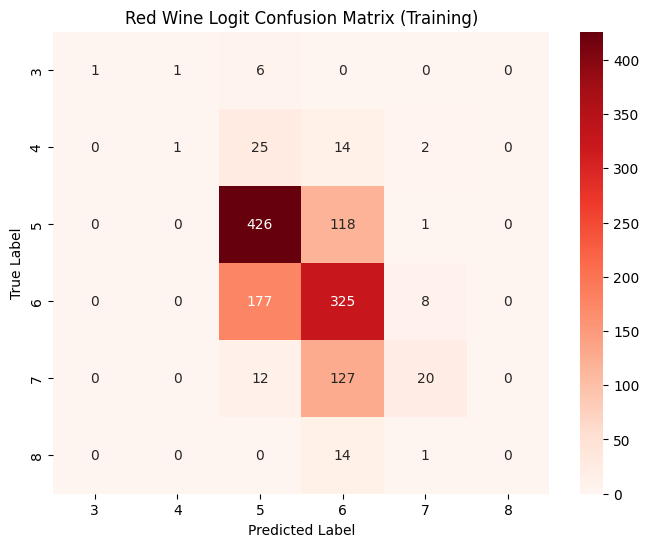

[1.         0.5        0.65944272 0.54347826 0.625      0.        ]


In [10]:
red_labels = range(3,9)

red_train_class_precision = confusion_matrix_and_class_precision(red_Y_train,
                                                                 red_logit_grid.predict(red_X_train),
                                                                 red_labels,
                                                                 "Red Wine Logit Confusion Matrix (Training)",
                                                                 "Reds")

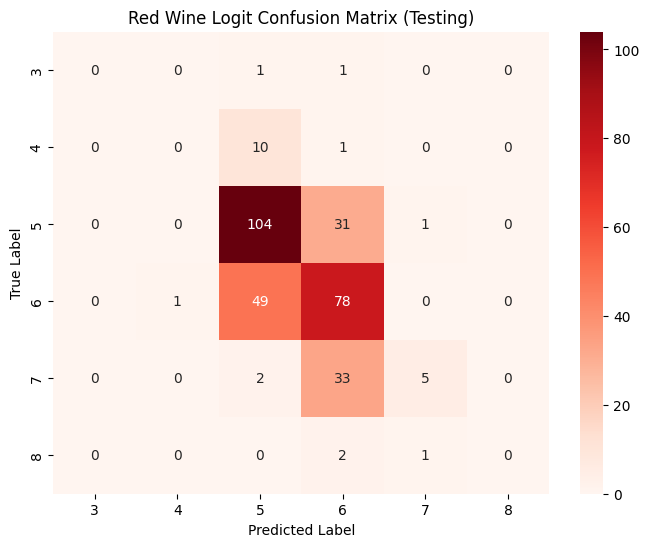

[0.         0.         0.62650602 0.53424658 0.71428571 0.        ]


In [11]:
red_test_class_precision = confusion_matrix_and_class_precision(red_Y_test,
                                                                red_logit_grid.predict(red_X_test),
                                                                red_labels,
                                                                "Red Wine Logit Confusion Matrix (Testing)",
                                                                "Reds")

In [12]:
from sklearn.metrics import accuracy_score

print("Accuracy:", accuracy_score(red_Y_test, red_logit_grid.predict(red_X_test)))

Accuracy: 0.584375


**Feature Selection**

In [13]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.svm import LinearSVC, SVC

red_sfs_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('sfs', SequentialFeatureSelector(LinearSVC(),
                                      n_features_to_select=1,
                                      direction='forward',
                                      scoring='precision_macro')),
    ('one-v-rest', OneVsRestClassifier(LogisticRegression()))
])

red_sfs_param_grid = {
    'sfs__n_features_to_select': np.arange(3, 11),
    'one-v-rest__estimator__penalty': ['l1', 'l2'],
    'one-v-rest__estimator__C': np.logspace(-2, 4, 7),
    'one-v-rest__estimator__solver': ['liblinear'],
    'one-v-rest__estimator__random_state': [42]
}

red_sfs_grid = GridSearchCV(red_sfs_pipeline, red_sfs_param_grid, scoring='precision_macro', n_jobs=-1)
red_sfs_grid.fit(red_X_train, red_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVC(),
                                                                  n_features_to_select=1,
                                                                  scoring='precision_macro')),
                                       ('one-v-rest',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             n_jobs=-1,
             param_grid={'one-v-rest__estimator__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'one-v-rest__estimator__penalty': ['l1', 'l2'],
                         'one-v-rest__estimator__random_state': [42],
                         'one-v-rest__estimator__solver': ['liblinear'],
                         'sfs__n_features_to_select': array([ 3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='precision_macro')

In [14]:
red_sfs_grid.best_params_

{'one-v-rest__estimator__C': np.float64(10.0),
 'one-v-rest__estimator__penalty': 'l1',
 'one-v-rest__estimator__random_state': 42,
 'one-v-rest__estimator__solver': 'liblinear',
 'sfs__n_features_to_select': np.int64(9)}

We can inspect what predictors were chosen by the sequential feature selector:

In [15]:
red_X_train.columns[red_sfs_grid.best_estimator_['sfs'].get_support()]

Index(['volatile acidity', 'citric acid', 'residual sugar', 'chlorides',
       'free sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol'],
      dtype='object')

And finally, look at the confusion matrix and class precision scores for logistic regression with feature selection:

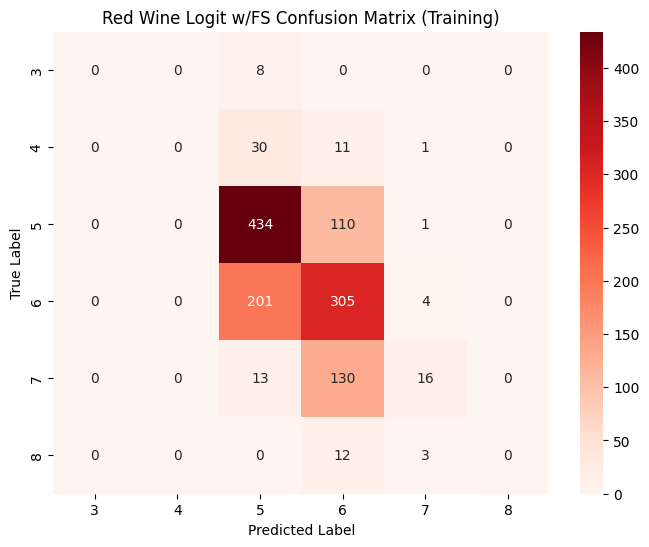

[0.         0.         0.63265306 0.53697183 0.64       0.        ]


In [16]:
red_sfs_train_class_precision = confusion_matrix_and_class_precision(red_Y_train,
                                                                     red_sfs_grid.predict(red_X_train),
                                                                     red_labels,
                                                                     "Red Wine Logit w/FS Confusion Matrix (Training)",
                                                                     "Reds")

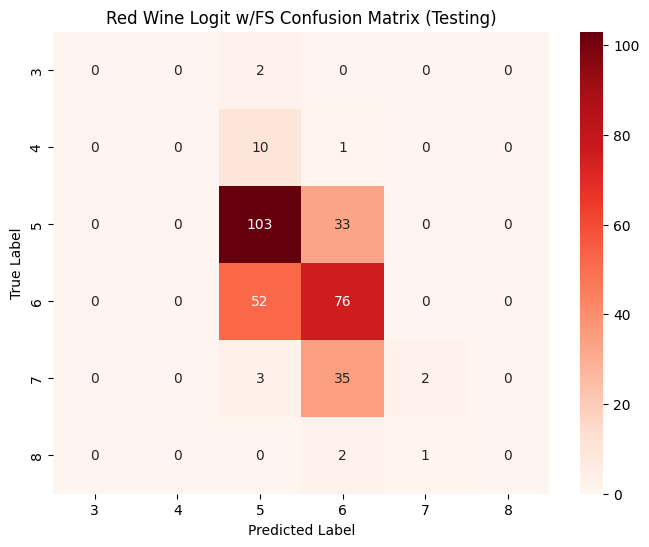

[0.         0.         0.60588235 0.5170068  0.66666667 0.        ]


In [17]:
red_sfs_test_class_precision = confusion_matrix_and_class_precision(red_Y_test,
                                                                    red_sfs_grid.predict(red_X_test),
                                                                    red_labels,
                                                                    "Red Wine Logit w/FS Confusion Matrix (Testing)",
                                                                    "Reds")

In [18]:
print("Accuracy:", accuracy_score(red_Y_test, red_sfs_grid.predict(red_X_test)))

Accuracy: 0.565625


Comparing all the class precisions:

In [19]:
red_class_precision_table = pd.DataFrame(zip(red_train_class_precision, red_test_class_precision,
                                             red_sfs_train_class_precision, red_sfs_test_class_precision),
                                         columns=['Training', 'Testing', 'FS Training', 'FS Testing'],
                                         index=red_labels)
red_class_precision_table.loc['Avg'] = red_class_precision_table.mean()

red_class_precision_table

,Training,Testing,FS Training,FS Testing
3,1.000000,0.000000,0.000000,0.000000
4,0.500000,0.000000,0.000000,0.000000
5,0.659443,0.626506,0.632653,0.605882
6,0.543478,0.534247,0.536972,0.517007
7,0.625000,0.714286,0.640000,0.666667
8,0.000000,0.000000,0.000000,0.000000
Avg,0.554653,0.312506,0.301604,0.298259


### White Wine

In [20]:
white_logit_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('one-v-rest', OneVsRestClassifier(LogisticRegression()))
])

white_logit_param_grid = {
    'one-v-rest__estimator__penalty': ['l1', 'l2'],
    'one-v-rest__estimator__C': np.logspace(-2, 4, 7),
    'one-v-rest__estimator__solver': ['liblinear'],
    'one-v-rest__estimator__random_state': [42]
}

white_logit_grid = GridSearchCV(white_logit_pipeline, white_logit_param_grid, scoring='precision_macro')
white_logit_grid.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('one-v-rest',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             param_grid={'one-v-rest__estimator__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'one-v-rest__estimator__penalty': ['l1', 'l2'],
                         'one-v-rest__estimator__random_state': [42],
                         'one-v-rest__estimator__solver': ['liblinear']},
             scoring='precision_macro')

In [21]:
white_logit_grid.best_params_

{'one-v-rest__estimator__C': np.float64(1.0),
 'one-v-rest__estimator__penalty': 'l2',
 'one-v-rest__estimator__random_state': 42,
 'one-v-rest__estimator__solver': 'liblinear'}

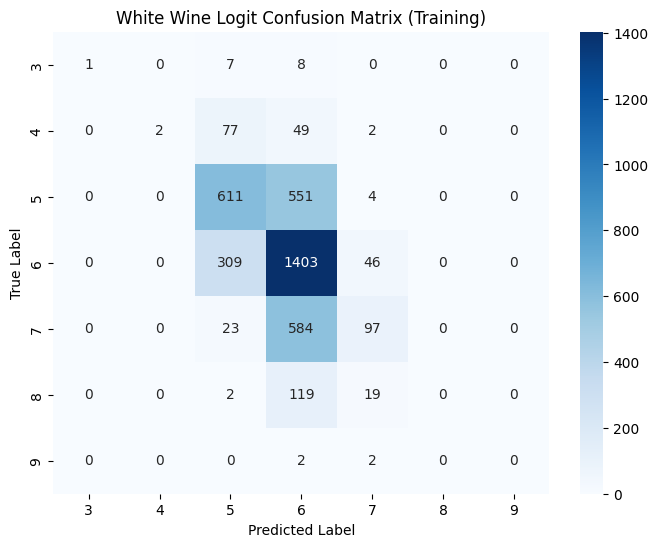

[1.         1.         0.59378037 0.51656848 0.57058824 0.
 0.        ]


In [22]:
white_labels = range(3,10)

white_train_class_precision = confusion_matrix_and_class_precision(white_Y_train,
                                                                   white_logit_grid.predict(white_X_train),
                                                                   white_labels,
                                                                   "White Wine Logit Confusion Matrix (Training)",
                                                                   "Blues")

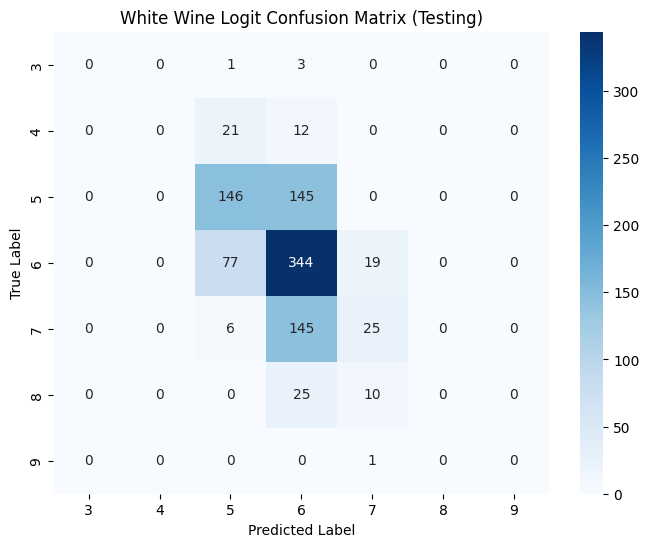

[0.         0.         0.58167331 0.51038576 0.45454545 0.
 0.        ]


In [23]:
white_test_class_precision = confusion_matrix_and_class_precision(white_Y_test,
                                                                  white_logit_grid.predict(white_X_test),
                                                                  white_labels,
                                                                  "White Wine Logit Confusion Matrix (Testing)",
                                                                  "Blues")

In [27]:
print("Accuracy:", accuracy_score(white_Y_test, white_logit_grid.predict(white_X_test)))

Accuracy: 0.5255102040816326


**Feature Selection**

In [28]:
white_sfs_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('sfs', SequentialFeatureSelector(LinearSVC(),
                                      n_features_to_select=1,
                                      direction='forward',
                                      scoring='precision_macro')),
    ('one-v-rest', OneVsRestClassifier(LogisticRegression()))
])

white_sfs_param_grid = {
    'sfs__n_features_to_select': np.arange(3, 11),
    'one-v-rest__estimator__penalty': ['l1', 'l2'],
    'one-v-rest__estimator__C': np.logspace(-2, 4, 7),
    'one-v-rest__estimator__solver': ['liblinear'],
    'one-v-rest__estimator__random_state': [42]
}

white_sfs_grid = GridSearchCV(white_sfs_pipeline, white_sfs_param_grid, scoring='precision_macro', n_jobs=-1)
white_sfs_grid.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVC(),
                                                                  n_features_to_select=1,
                                                                  scoring='precision_macro')),
                                       ('one-v-rest',
                                        OneVsRestClassifier(estimator=LogisticRegression()))]),
             n_jobs=-1,
             param_grid={'one-v-rest__estimator__C': array([1.e-02, 1.e-01, 1.e+00, 1.e+01, 1.e+02, 1.e+03, 1.e+04]),
                         'one-v-rest__estimator__penalty': ['l1', 'l2'],
                         'one-v-rest__estimator__random_state': [42],
                         'one-v-rest__estimator__solver': ['liblinear'],
                         'sfs__n_features_to_select': array([ 3,  4,  5,  6,  7,  8,  9, 10])},
             scoring='precision_macro')

In [29]:
white_sfs_grid.best_params_

{'one-v-rest__estimator__C': np.float64(10.0),
 'one-v-rest__estimator__penalty': 'l2',
 'one-v-rest__estimator__random_state': 42,
 'one-v-rest__estimator__solver': 'liblinear',
 'sfs__n_features_to_select': np.int64(4)}

Features selected:

In [30]:
white_X_train.columns[white_sfs_grid.best_estimator_['sfs'].get_support()]

Index(['total sulfur dioxide', 'pH', 'sulphates', 'alcohol'], dtype='object')

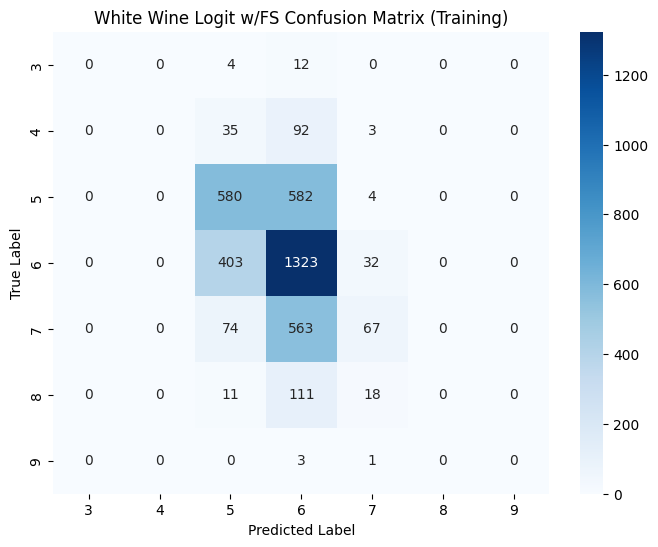

[0.         0.         0.52393857 0.49255398 0.536      0.
 0.        ]


In [31]:
white_sfs_train_class_precision = confusion_matrix_and_class_precision(white_Y_train,
                                                                       white_sfs_grid.predict(white_X_train),
                                                                       white_labels,
                                                                       "White Wine Logit w/FS Confusion Matrix (Training)",
                                                                       "Blues")

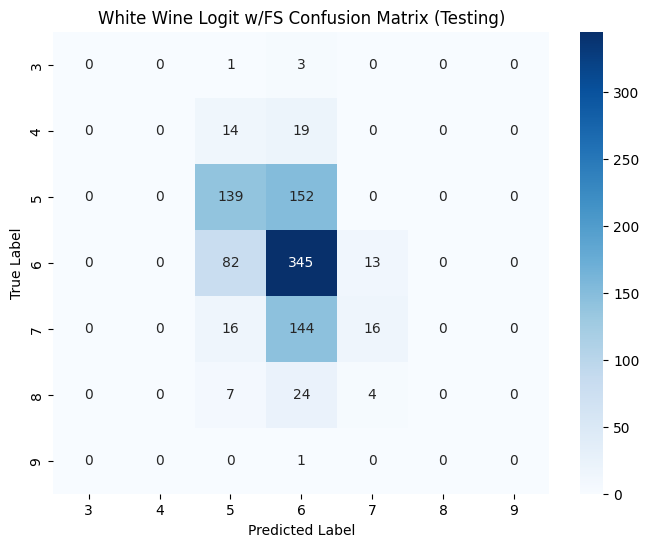

[0.         0.         0.53667954 0.50145349 0.48484848 0.
 0.        ]


In [32]:
white_sfs_test_class_precision = confusion_matrix_and_class_precision(white_Y_test,
                                                                      white_sfs_grid.predict(white_X_test),
                                                                      white_labels,
                                                                      "White Wine Logit w/FS Confusion Matrix (Testing)",
                                                                      "Blues")

In [33]:
print("Accuracy:", accuracy_score(white_Y_test, white_sfs_grid.predict(white_X_test)))

Accuracy: 0.5102040816326531


In [34]:
white_class_precision_table = pd.DataFrame(zip(white_train_class_precision, white_test_class_precision,
                                               white_sfs_train_class_precision, white_sfs_test_class_precision),
                                           columns=['Training', 'Testing', 'FS Training', 'FS Testing'],
                                           index=white_labels)
white_class_precision_table.loc['Avg'] = white_class_precision_table.mean()

white_class_precision_table

,Training,Testing,FS Training,FS Testing
3,1.000000,0.000000,0.000000,0.000000
4,1.000000,0.000000,0.000000,0.000000
5,0.593780,0.581673,0.523939,0.536680
6,0.516568,0.510386,0.492554,0.501453
7,0.570588,0.454545,0.536000,0.484848
8,0.000000,0.000000,0.000000,0.000000
9,0.000000,0.000000,0.000000,0.000000
Avg,0.525848,0.220944,0.221785,0.217569


## Support Vector Machines

Through testing, we've determined that the polynomial kernel is the optimal kernel to use for SVC on the wine data, so we only tune hyperparameters for the polynomial kernel. Additionally, we apply RobustScaler to deal with the skewed distribution of our predictors, as it is less sensitive to outliers and often suitable for SVM tasks.

### Red Wine

In [20]:
from sklearn.svm import SVC

red_svm_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVC(random_state=42))
])

red_svm_param_grid = {
    'svm__kernel': ['poly'],
    'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0, 0.25, 1, 2, 5]
}

red_svm_grid = GridSearchCV(red_svm_pipeline, red_svm_param_grid, scoring='precision_macro', n_jobs=-1)
red_svm_grid.fit(red_X_train, red_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'svm__coef0': [0, 0.25, 1, 2, 5],
                         'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['poly']},
             scoring='precision_macro')

In [21]:
red_svm_grid.best_params_

{'svm__C': 100.0,
 'svm__coef0': 0,
 'svm__degree': 4,
 'svm__gamma': 'scale',
 'svm__kernel': 'poly'}

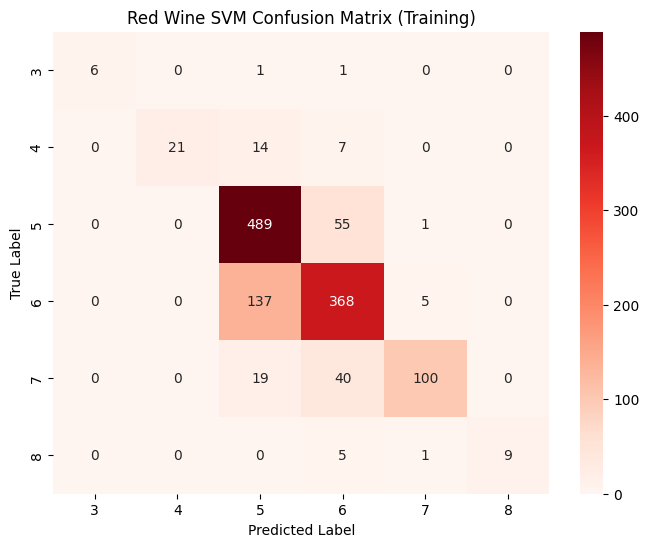

[1.         1.         0.74090909 0.77310924 0.93457944 1.        ]


In [22]:
red_labels = range(3,9)
red_svm_train_class_precision = confusion_matrix_and_class_precision(red_Y_train,
                                                                     red_svm_grid.predict(red_X_train),
                                                                     red_labels,
                                                                     "Red Wine SVM Confusion Matrix (Training)",
                                                                     "Reds")

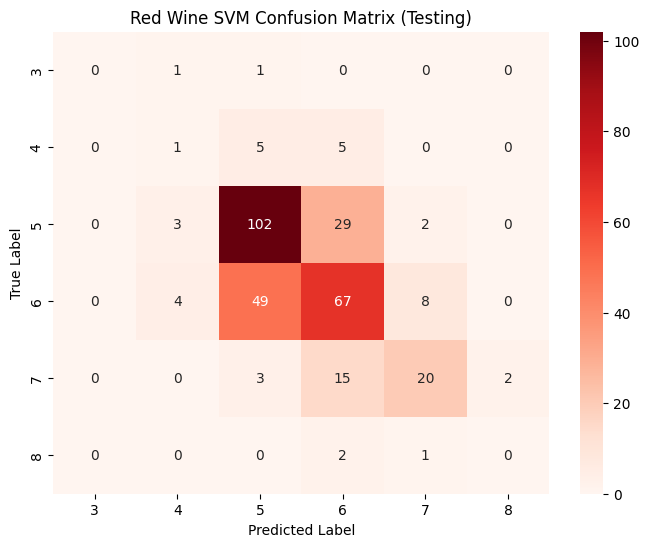

[0.         0.11111111 0.6375     0.56779661 0.64516129 0.        ]


In [23]:
red_svm_test_class_precision = confusion_matrix_and_class_precision(red_Y_test,
                                                                    red_svm_grid.predict(red_X_test),
                                                                    red_labels,
                                                                    "Red Wine SVM Confusion Matrix (Testing)",
                                                                    "Reds")

In [24]:
print("Accuracy:", accuracy_score(red_Y_test, red_svm_grid.predict(red_X_test)))

Accuracy: 0.59375


**Feature Selection**

In [43]:
red_svm_sfs_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('sfs', SequentialFeatureSelector(LinearSVC(),
                                      n_features_to_select=1,
                                      direction='forward',
                                      scoring='precision_macro')),
    ('svm', SVC(random_state=42))
])

red_svm_sfs_param_grid = {
    'sfs__n_features_to_select': np.arange(3, 11),
    'svm__kernel': ['poly'],
    'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0, 0.25, 1, 2, 5]
}

red_svm_sfs_grid = GridSearchCV(red_svm_sfs_pipeline, red_svm_sfs_param_grid, scoring='precision_macro', n_jobs=-1)
red_svm_sfs_grid.fit(red_X_train, red_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVC(),
                                                                  n_features_to_select=1,
                                                                  scoring='precision_macro')),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'sfs__n_features_to_select': array([ 3,  4,  5,  6,  7,  8,  9, 10]),
                         'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'svm__coef0': [0, 0.25, 1, 2, 5],
                         'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['poly']},
             scoring='precision_macro')

In [45]:
red_svm_sfs_grid.best_params_

{'sfs__n_features_to_select': np.int64(5),
 'svm__C': 100.0,
 'svm__coef0': 0.25,
 'svm__degree': 4,
 'svm__gamma': 'scale',
 'svm__kernel': 'poly'}

Features selected:

In [46]:
red_X_train.columns[red_svm_sfs_grid.best_estimator_['sfs'].get_support()]

Index(['volatile acidity', 'residual sugar', 'chlorides', 'density',
       'alcohol'],
      dtype='object')

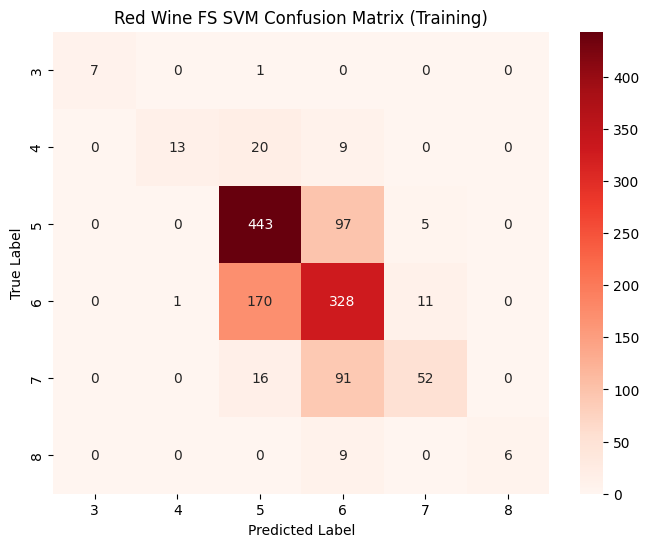

[1.         0.92857143 0.68153846 0.61423221 0.76470588 1.        ]


In [47]:
red_svm_sfs_train_class_precision = confusion_matrix_and_class_precision(red_Y_train,
                                                                         red_svm_sfs_grid.predict(red_X_train),
                                                                         red_labels,
                                                                         "Red Wine FS SVM Confusion Matrix (Training)",
                                                                         "Reds")

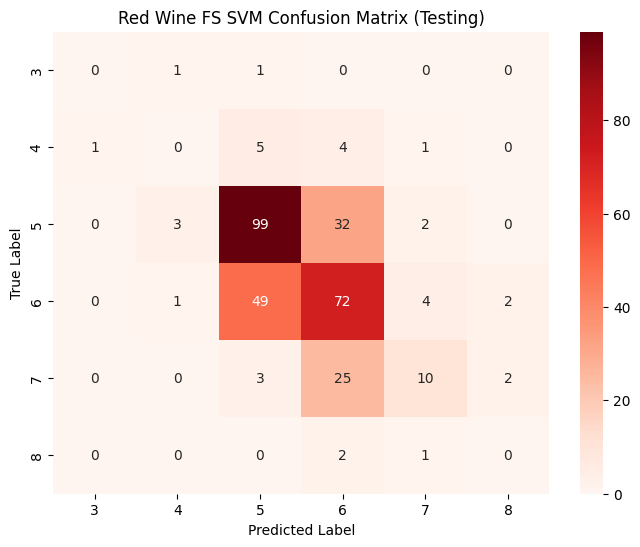

[0.         0.         0.63057325 0.53333333 0.55555556 0.        ]


In [48]:
red_svm_sfs_test_class_precision = confusion_matrix_and_class_precision(red_Y_test,
                                                                        red_svm_sfs_grid.predict(red_X_test),
                                                                        red_labels,
                                                                        "Red Wine FS SVM Confusion Matrix (Testing)",
                                                                        "Reds")

In [49]:
print("Accuracy:", accuracy_score(red_Y_test, red_svm_sfs_grid.predict(red_X_test)))

Accuracy: 0.565625


Summary of results:

In [50]:
red_svm_class_precision_table = pd.DataFrame(zip(red_svm_train_class_precision, red_svm_test_class_precision,
                                                 red_svm_sfs_train_class_precision, red_svm_sfs_test_class_precision),
                                         columns=['Training', 'Testing', 'FS Training', 'FS Testing'],
                                         index=red_labels)
red_svm_class_precision_table.loc['Avg'] = red_svm_class_precision_table.mean()

red_svm_class_precision_table

,Training,Testing,FS Training,FS Testing
3,1.000000,0.000000,1.000000,0.000000
4,1.000000,0.111111,0.928571,0.000000
5,0.740909,0.637500,0.681538,0.630573
6,0.773109,0.567797,0.614232,0.533333
7,0.934579,0.645161,0.764706,0.555556
8,1.000000,0.000000,1.000000,0.000000
Avg,0.908100,0.326928,0.831508,0.286577


### White Wine

In [25]:
white_svm_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('svm', SVC(random_state=42))
])

white_svm_param_grid = {
    'svm__kernel': ['poly'],
    'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0, 0.25, 1, 2, 5]
}

white_svm_grid = GridSearchCV(white_svm_pipeline, white_svm_param_grid, scoring='precision_macro', n_jobs=-1)
white_svm_grid.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'svm__coef0': [0, 0.25, 1, 2, 5],
                         'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['poly']},
             scoring='precision_macro')

In [26]:
white_svm_grid.best_params_

{'svm__C': 10.0,
 'svm__coef0': 2,
 'svm__degree': 3,
 'svm__gamma': 'auto',
 'svm__kernel': 'poly'}

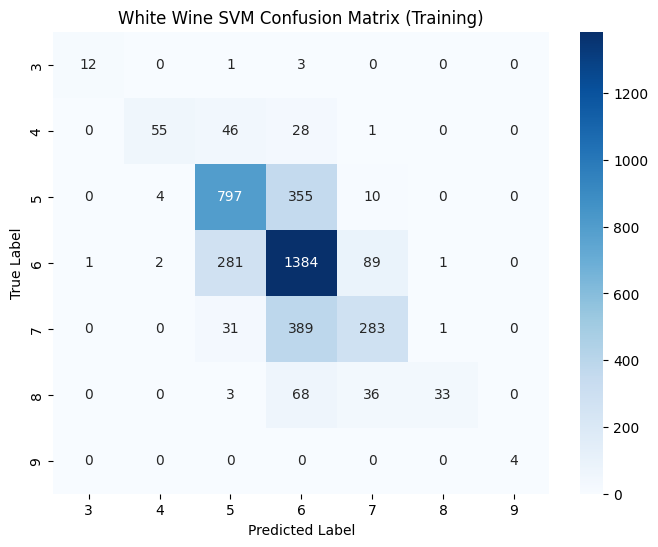

[0.92307692 0.90163934 0.68766178 0.62146385 0.67541766 0.94285714
 1.        ]


In [27]:
white_labels = range(3,10)
white_svm_train_class_precision = confusion_matrix_and_class_precision(white_Y_train,
                                                                       white_svm_grid.predict(white_X_train),
                                                                       white_labels,
                                                                       "White Wine SVM Confusion Matrix (Training)",
                                                                       "Blues")

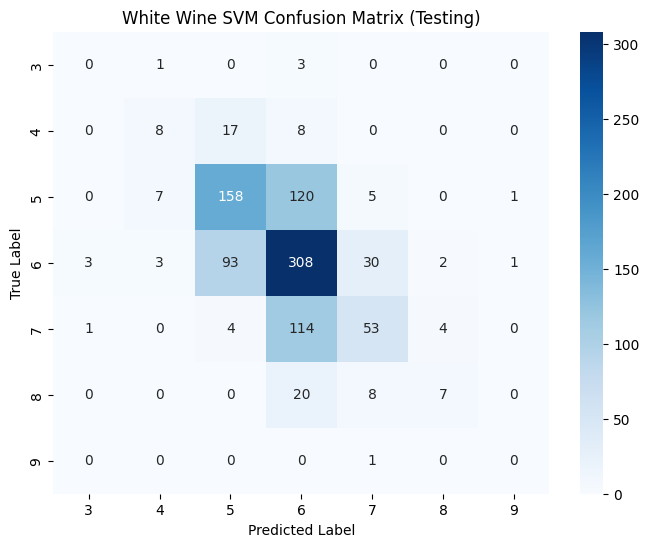

[0.         0.42105263 0.58088235 0.53752182 0.54639175 0.53846154
 0.        ]


In [28]:
white_svm_test_class_precision = confusion_matrix_and_class_precision(white_Y_test,
                                                                      white_svm_grid.predict(white_X_test),
                                                                      white_labels,
                                                                      "White Wine SVM Confusion Matrix (Testing)",
                                                                      "Blues")

In [29]:
print("Accuracy:", accuracy_score(white_Y_test, white_svm_grid.predict(white_X_test)))

Accuracy: 0.5448979591836735


#### Feature Selection

To make incremental progress feature selection, we perform hyperparameter tuning with feature selection using 2 values for `n_features_to_select` at a time:

##### n=[3,4]

In [30]:
white_svm_sfs_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('sfs', SequentialFeatureSelector(LinearSVC(),
                                      n_features_to_select=1,
                                      direction='forward',
                                      scoring='precision_macro')),
    ('svm', SVC(random_state=42))
])

white_svm_sfs_param_grid = {
    'sfs__n_features_to_select': [3, 4],
    'svm__kernel': ['poly'],
    'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0, 0.25, 1, 2, 5]
}

white_svm_sfs_grid = GridSearchCV(white_svm_sfs_pipeline, white_svm_sfs_param_grid, scoring='precision_macro', n_jobs=-1)
white_svm_sfs_grid.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVC(),
                                                                  n_features_to_select=1,
                                                                  scoring='precision_macro')),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'sfs__n_features_to_select': [3, 4],
                         'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'svm__coef0': [0, 0.25, 1, 2, 5],
                         'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['poly']},
             scoring='precision_macro')

In [31]:
white_svm_sfs_grid.best_params_

{'sfs__n_features_to_select': 4,
 'svm__C': 100.0,
 'svm__coef0': 1,
 'svm__degree': 4,
 'svm__gamma': 'auto',
 'svm__kernel': 'poly'}

In [32]:
precision_score(white_Y_train, white_svm_sfs_grid.predict(white_X_train), average='macro')

0.7127141218274842

##### n=[5,6]

In [69]:
white_svm_sfs_param_grid_2 = {
    'sfs__n_features_to_select': [5, 6],
    'svm__kernel': ['poly'],
    'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0, 0.25, 1, 2, 5]
}

white_svm_sfs_grid_2 = GridSearchCV(white_svm_sfs_pipeline, white_svm_sfs_param_grid_2, scoring='precision_macro', n_jobs=-1)
white_svm_sfs_grid_2.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVC(),
                                                                  n_features_to_select=1,
                                                                  scoring='precision_macro')),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'sfs__n_features_to_select': [5, 6],
                         'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'svm__coef0': [0, 0.25, 1, 2, 5],
                         'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['poly']},
             scoring='precision_macro')

In [71]:
white_svm_sfs_grid_2.best_params_

{'sfs__n_features_to_select': 5,
 'svm__C': 100.0,
 'svm__coef0': 5,
 'svm__degree': 4,
 'svm__gamma': 'auto',
 'svm__kernel': 'poly'}

In [72]:
precision_score(white_Y_train, white_svm_sfs_grid_2.predict(white_X_train), average='macro')

0.7015090444590946

##### n=[7,8]

In [74]:
white_svm_sfs_param_grid_3 = {
    'sfs__n_features_to_select': [7, 8],
    'svm__kernel': ['poly'],
    'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0, 0.25, 1, 2, 5]
}

white_svm_sfs_grid_3 = GridSearchCV(white_svm_sfs_pipeline, white_svm_sfs_param_grid_3, scoring='precision_macro', n_jobs=-1)
white_svm_sfs_grid_3.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVC(),
                                                                  n_features_to_select=1,
                                                                  scoring='precision_macro')),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'sfs__n_features_to_select': [7, 8],
                         'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'svm__coef0': [0, 0.25, 1, 2, 5],
                         'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['poly']},
             scoring='precision_macro')

In [76]:
white_svm_sfs_grid_3.best_params_

{'sfs__n_features_to_select': 8,
 'svm__C': 10.0,
 'svm__coef0': 0,
 'svm__degree': 3,
 'svm__gamma': 'auto',
 'svm__kernel': 'poly'}

In [77]:
precision_score(white_Y_train, white_svm_sfs_grid_3.predict(white_X_train), average='macro')

0.6440341821639677

##### n=[9,10]

In [79]:
white_svm_sfs_param_grid_4 = {
    'sfs__n_features_to_select': [9, 10],
    'svm__kernel': ['poly'],
    'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
    'svm__gamma': ['scale', 'auto'],
    'svm__degree': [2, 3, 4],
    'svm__coef0': [0, 0.25, 1, 2, 5]
}

white_svm_sfs_grid_4 = GridSearchCV(white_svm_sfs_pipeline, white_svm_sfs_param_grid_4, scoring='precision_macro', n_jobs=-1)
white_svm_sfs_grid_4.fit(white_X_train, white_Y_train)

GridSearchCV(estimator=Pipeline(steps=[('scaler', RobustScaler()),
                                       ('sfs',
                                        SequentialFeatureSelector(estimator=LinearSVC(),
                                                                  n_features_to_select=1,
                                                                  scoring='precision_macro')),
                                       ('svm', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'sfs__n_features_to_select': [9, 10],
                         'svm__C': [0.01, 0.1, 1.0, 10.0, 100.0],
                         'svm__coef0': [0, 0.25, 1, 2, 5],
                         'svm__degree': [2, 3, 4],
                         'svm__gamma': ['scale', 'auto'],
                         'svm__kernel': ['poly']},
             scoring='precision_macro')

In [81]:
white_svm_sfs_grid_4.best_params_

{'sfs__n_features_to_select': 9,
 'svm__C': 1.0,
 'svm__coef0': 0,
 'svm__degree': 2,
 'svm__gamma': 'auto',
 'svm__kernel': 'poly'}

In [82]:
precision_score(white_Y_train, white_svm_sfs_grid_4.predict(white_X_train), average='macro')

0.494428462783438

#### Evaluation

The highest macro precision score was obtained from the first grid search, so we use that to evaluate feature selection.

In [33]:
white_svm_sfs_grid.best_params_

{'sfs__n_features_to_select': 4,
 'svm__C': 100.0,
 'svm__coef0': 1,
 'svm__degree': 4,
 'svm__gamma': 'auto',
 'svm__kernel': 'poly'}

Features selected:

In [34]:
white_X_train.columns[white_svm_sfs_grid.best_estimator_['sfs'].get_support()]

Index(['total sulfur dioxide', 'pH', 'sulphates', 'alcohol'], dtype='object')

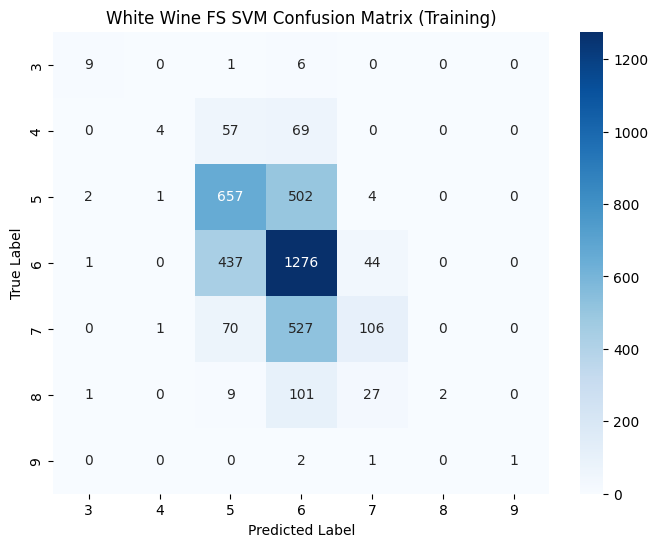

[0.69230769 0.66666667 0.53371243 0.51389448 0.58241758 1.
 1.        ]


In [35]:
white_svm_sfs_train_class_precision = confusion_matrix_and_class_precision(white_Y_train,
                                                                           white_svm_sfs_grid.predict(white_X_train),
                                                                           white_labels,
                                                                           "White Wine FS SVM Confusion Matrix (Training)",
                                                                           "Blues")

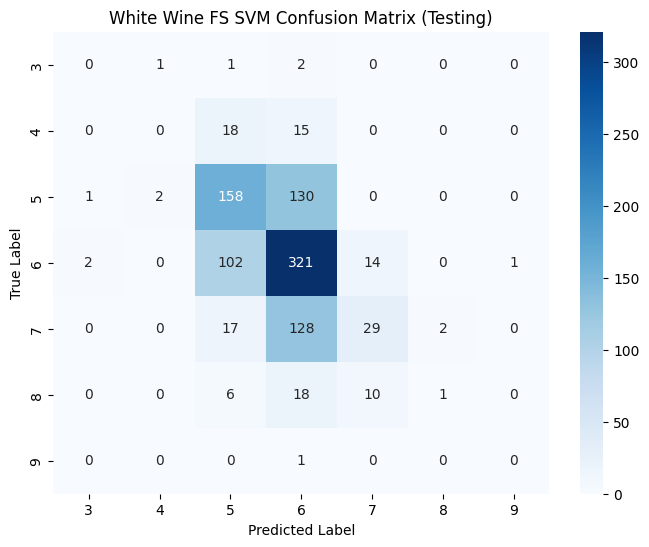

[0.         0.         0.52317881 0.52195122 0.54716981 0.33333333
 0.        ]


In [36]:
white_svm_sfs_test_class_precision = confusion_matrix_and_class_precision(white_Y_test,
                                                                          white_svm_sfs_grid.predict(white_X_test),
                                                                          white_labels,
                                                                          "White Wine FS SVM Confusion Matrix (Testing)",
                                                                          "Blues")

In [37]:
print("Accuracy:", accuracy_score(white_Y_test, white_svm_sfs_grid.predict(white_X_test)))

Accuracy: 0.5193877551020408


Summary of results:

In [38]:
white_svm_class_precision_table = pd.DataFrame(zip(white_svm_train_class_precision, white_svm_test_class_precision,
                                                   white_svm_sfs_train_class_precision, white_svm_sfs_test_class_precision),
                                               columns=['Training', 'Testing', 'FS Training', 'FS Testing'],
                                               index=white_labels)
white_svm_class_precision_table.loc['Avg'] = white_svm_class_precision_table.mean()

white_svm_class_precision_table

,Training,Testing,FS Training,FS Testing
3,0.923077,0.000000,0.692308,0.000000
4,0.901639,0.421053,0.666667,0.000000
5,0.687662,0.580882,0.533712,0.523179
6,0.621464,0.537522,0.513894,0.521951
7,0.675418,0.546392,0.582418,0.547170
8,0.942857,0.538462,1.000000,0.333333
9,1.000000,0.000000,1.000000,0.000000
Avg,0.821731,0.374901,0.712714,0.275090
